### Importing libraries

Exploring store sales using pandas, seaborn, and SQL.\
Data: https://www.kaggle.com/competitions/rossmann-store-sales/data?select=store.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, MetaData, Table

sns.set_theme(style="whitegrid")

### Reading and first exploration of sales

In [2]:
sales = pd.read_csv('sales_data.csv')

C:\Users\roank\BTS\anaconda3\envs\DSF\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


##### Checking StateHoliday feature; due to warning

In [4]:
sales.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [5]:
holidays = {'a':'public holiday','b':'Easter holiday','c':'Christmas', 'n':'None'}

sales.StateHoliday = np.where(sales.StateHoliday.isin(['0',0]), 'n', sales.StateHoliday)
sales.StateHoliday = sales.StateHoliday.map(holidays)
print(sales.StateHoliday.unique())

sales.StateHoliday = sales.StateHoliday.astype('category')
print(sales.StateHoliday.dtype)

['None' 'public holiday' 'Easter holiday' 'Christmas']
category


In [6]:
engine = create_engine('sqlite://')
sales.to_sql('sales',con = engine)
conn = engine.connect()

In [7]:
rs = conn.execute('SELECT * FROM sales LIMIT 5')
rs.fetchall()

[(0, 1, 5, '2015-07-31', 5263, 555, 1, 1, 'None', 1),
 (1, 2, 5, '2015-07-31', 6064, 625, 1, 1, 'None', 1),
 (2, 3, 5, '2015-07-31', 8314, 821, 1, 1, 'None', 1),
 (3, 4, 5, '2015-07-31', 13995, 1498, 1, 1, 'None', 1),
 (4, 5, 5, '2015-07-31', 4822, 559, 1, 1, 'None', 1)]

### Exploring the distributions of several features

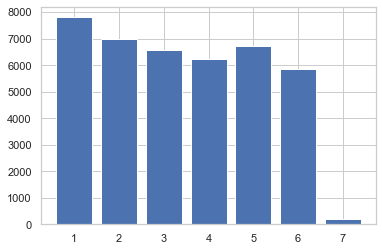

In [8]:
rs = conn.execute('SELECT DayofWeek, AVG(Sales) as mean_sales FROM sales\
                    Group By DayOfWeek')
results = rs.fetchall()
plt.bar(height = dict(results).values(),x = dict(results).keys());

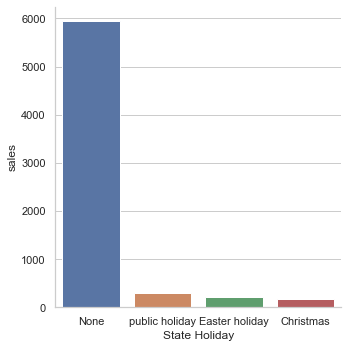

In [9]:
rs = conn.execute('SELECT StateHoliday, AVG(Sales) as mean_sales FROM sales\
                    Group By StateHoliday\
                    ORDER BY mean_sales DESC')
results = rs.fetchall()

sns.catplot(data=pd.DataFrame(results), x = 0, y = 1, kind = 'bar')
plt.xlabel('State Holiday')
plt.ylabel('sales');

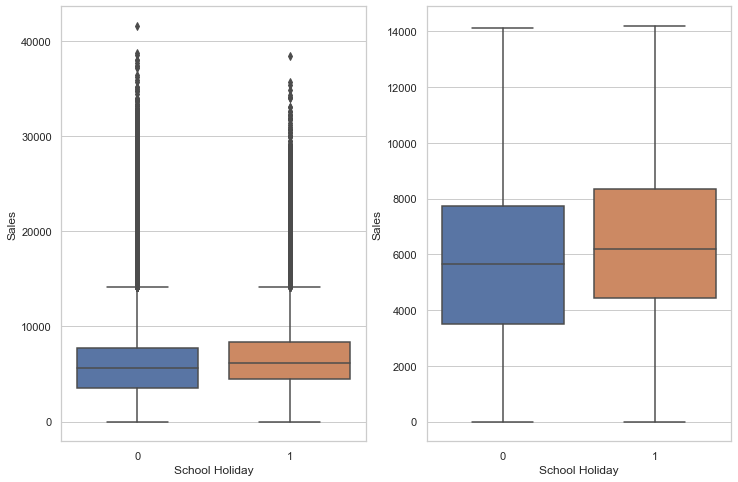

In [10]:
rs = conn.execute('SELECT SchoolHoliday, Sales FROM sales')
results = rs.fetchall()

fig, axes = plt.subplots(nrows =1, ncols = 2, figsize = (12,8))

sns.boxplot(ax = axes[0],data = pd.DataFrame(results), x = 0, y = 1)
sns.boxplot(ax = axes[1],data = pd.DataFrame(results), x = 0, y = 1, showfliers = False)
for ax in axes.flat:
    ax.set(xlabel='School Holiday', ylabel='Sales');

### Reading and exploring second, related dataset

In [11]:
stores = pd.read_csv('store.csv')

In [12]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
stores.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval'], axis = 1, inplace = True)

In [14]:
assortment = {'a':'basic','b':'extra','c':'extended'}
stores.Assortment =stores.Assortment.map(assortment)
print(stores.Assortment.unique())
stores.Assortment =stores.Assortment.astype('category')
print(stores.Assortment.dtype)

['basic' 'extended' 'extra']
category


### Exploring sales and stores dataset combined

In [15]:
stores.to_sql('stores',con = engine)

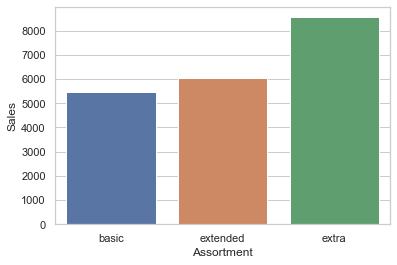

In [16]:
rs = conn.execute('SELECT Assortment, AVG(Sales) as mean_sales\
                    FROM sales\
                    LEFT JOIN stores\
                    USING (Store)\
                    GROUP BY Assortment')
results = rs.fetchall()
sns.barplot(data=pd.DataFrame(results), x = 0, y = 1)
plt.xlabel('Assortment')
plt.ylabel('Sales');

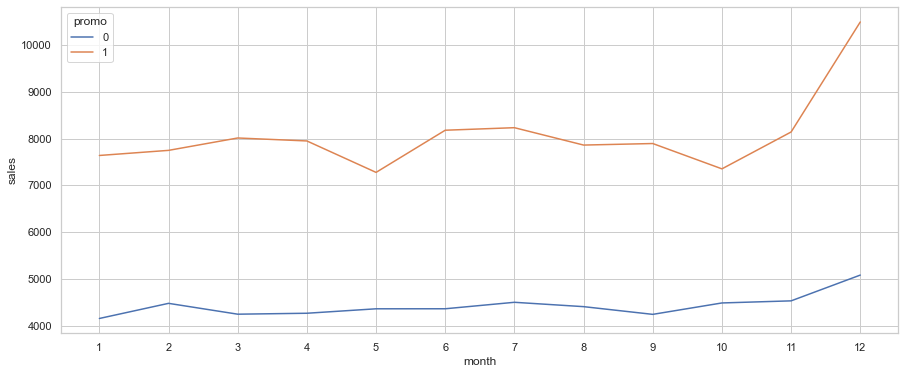

In [17]:
rs = conn.execute('SELECT StoreType, Promo, Date, Sales\
                    FROM sales\
                    LEFT JOIN stores\
                    USING (Store)')
results = rs.fetchall()

results = pd.DataFrame(results, columns = ['storetype','promo','date','sales'])
results['month'] = pd.DatetimeIndex(results.date).month

plt.figure(figsize = (15,6))

ax = sns.lineplot(data = results.groupby(['month','promo']).agg({'sales':'mean'}), x = 'month', y = 'sales', hue = 'promo')
plt.xticks(np.linspace(1,12,12));

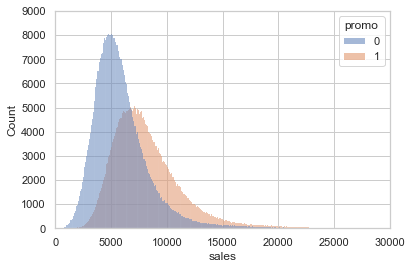

In [18]:
sns.histplot(data = results, x = 'sales', hue = 'promo')
plt.ylim([0,9000])
plt.xlim([0,30000]);

In [19]:
promo_sales = results[results.promo == 1]
regular_sales = results[results.promo == 0]

print('Promo sales: \n',promo_sales.sales.describe())
print('\nRegular sales: \n',regular_sales.sales.describe())

Promo sales: 
 count    388080.000000
mean       7991.152046
std        3419.025495
min           0.000000
25%        5922.000000
50%        7553.000000
75%        9603.000000
max       38722.000000
Name: sales, dtype: float64

Regular sales: 
 count    629129.000000
mean       4406.050805
std        3442.450020
min           0.000000
25%           0.000000
50%        4622.000000
75%        6367.000000
max       41551.000000
Name: sales, dtype: float64
